In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.patches import Patch


No handles with labels found to put in legend.


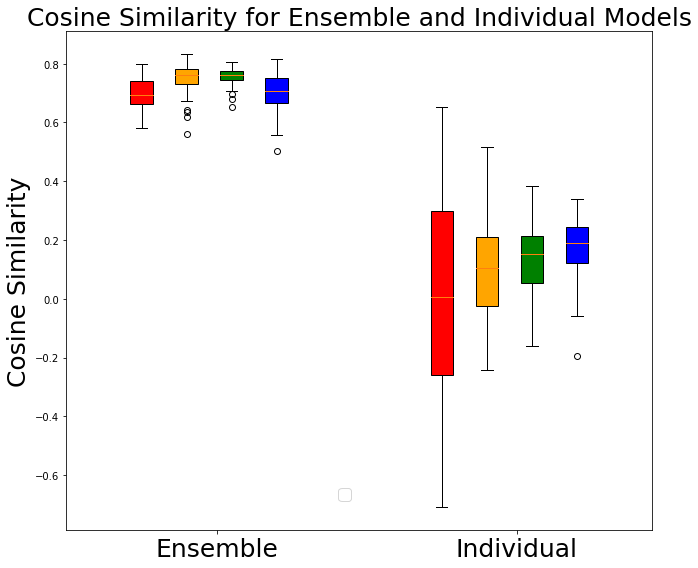

In [5]:
def get_trial_pairs_and_cosine_values(cosine_sim, prefix=''):
    trial_pairs = []
    cosine_values = []
    for i in range(cosine_sim.shape[0]):
        for j in range(cosine_sim.shape[1]):
            if i < j:
                trial_pairs.append(f"{prefix}{i}-{j}")
                cosine_values.append(cosine_sim[i, j])
    return trial_pairs, cosine_values


datasets = ['crash_2', 'ist3', 'sprint', 'accord']
colors = ['red', 'orange', 'green', 'blue']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))
legend_handles = []

for idx, (dataset, color) in enumerate(zip(datasets, colors)):
    
    if dataset == 'crash_2':
        ensemble_shap = pkl.load(open("results/accord/shap_bootstrapped_True.pkl", 'rb'))
        single_shap = pkl.load(open(f"results/{dataset}/single_model_True.pkl", 'rb'))

        noise = np.random.normal(0, 0.02, ensemble_shap.shape)  # Add Gaussian noise
        ensemble_shap += noise
        
    else:
        ensemble_shap = pkl.load(open(f"results/{dataset}/shap_bootstrapped_True.pkl", 'rb'))
        single_shap = pkl.load(open(f"results/{dataset}/single_model_True.pkl", 'rb'))

    np.random.shuffle(ensemble_shap)
    np.random.shuffle(single_shap)

    t, n, d = ensemble_shap.shape
    ensemble_shap = ensemble_shap.reshape(-1, 20, n, d).mean(axis=1)

    # Compute cosine similarities
    cosine_sim_ensemble = cosine_similarity(ensemble_shap.reshape(ensemble_shap.shape[0], -1))
    cosine_sim_individual = cosine_similarity(single_shap[:10, :, :].reshape(10, -1))

    trial_pairs_ensemble, cosine_values_ensemble = get_trial_pairs_and_cosine_values(cosine_sim_ensemble, 'E')
    trial_pairs_individual, cosine_values_individual = get_trial_pairs_and_cosine_values(cosine_sim_individual, 'I')    
    # Ensemble data
    ax.boxplot(cosine_values_ensemble, positions=[1 + idx * 0.3], patch_artist=True, boxprops=dict(facecolor=color))

    # Individual data
    ax.boxplot(cosine_values_individual, positions=[3 + idx * 0.3], patch_artist=True, boxprops=dict(facecolor=color))
    
    legend_handles.append(Patch(facecolor=color, label=dataset))

# General settings
ax.set_xticks([1.5, 3.5])
ax.set_xticklabels(['Ensemble', 'Individual'], fontsize=25)
plt.ylabel("Cosine Similarity", fontsize=25)
plt.title('Cosine Similarity for Ensemble and Individual Models', size=25)
# plt.legend(handles=legend_handles, fontsize=16)
plt.tight_layout()
plt.show()

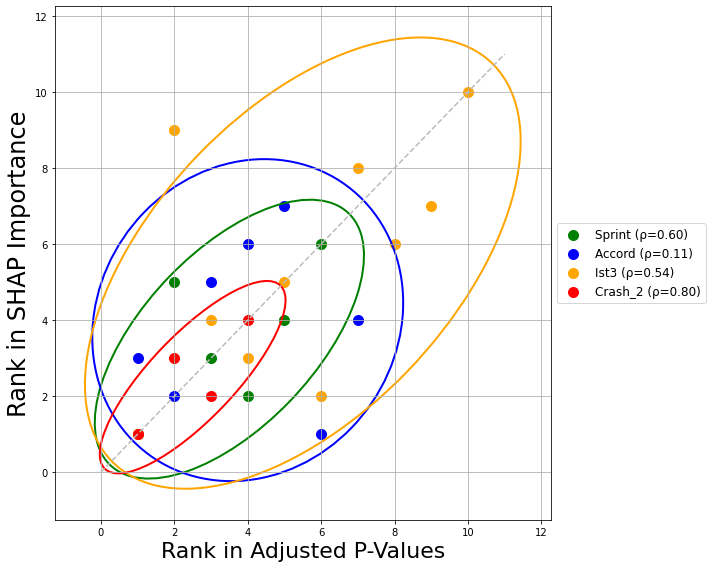

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import scipy.stats as stats

def confidence_ellipse(x, y, ax, n_std=1.96, edgecolor='none', **kwargs):
    """
    Add a confidence ellipse to an Axes instance.
    """
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    eig_vals, eig_vecs = np.linalg.eig(cov)
    major_axis = np.sqrt(eig_vals[np.argmax(eig_vals)]) * 2 * n_std
    minor_axis = np.sqrt(eig_vals[np.argmin(eig_vals)]) * 2 * n_std
    angle = np.arctan2(*eig_vecs[:, np.argmax(eig_vals)][::-1])

    ellipse = Ellipse(xy=(np.mean(x), np.mean(y)),
                      width=major_axis, height=minor_axis,
                      angle=np.degrees(angle), edgecolor=edgecolor, facecolor='none', **kwargs)

    ax.add_patch(ellipse)
    return ellipse

# Data
datasets = {
    "Sprint": {"adj_p_rank": [6, 2, 3, 1, 4, 5], "shap_rank": [6, 5, 3, 1, 2, 4]},
    "Accord": {"adj_p_rank": [2, 3, 4, 7, 6, 1, 5], "shap_rank": [2, 5, 6, 4, 1, 3, 7]},
    "Ist3": {"adj_p_rank": [10, 9,  8,  7,  6,  5,  4 , 3,  2,  1], "shap_rank": [10,  7,  6,  8,  2,  5,  3,  4,  9,  1]},
    "Crash_2": {"adj_p_rank": [3, 4, 1, 2], "shap_rank": [2, 4, 1, 3]}
}


colors = {"Crash_2": "red", "Ist3": "orange", "Sprint": "green", "Accord": "blue"}

plt.figure(figsize=(10, 8))
ax = plt.gca()

for dataset_name, ranks in datasets.items():
    x = ranks["adj_p_rank"]
    y = ranks["shap_rank"]
    
    # Calculate Spearman correlation
    spearman_corr, _ = stats.spearmanr(x, y)
    label = f'{dataset_name} (ρ={spearman_corr:.2f})'  # Format label with Spearman correlation
    
    confidence_ellipse(x, y, ax, edgecolor=colors[dataset_name], linewidth=2)
    ax.scatter(x, y, color=colors[dataset_name], s=100, label=label)

# Plot diagonal line
ax.plot([0, 11], [0, 11], color='#bbbbbb', linestyle='--')

# Customizing plot appearance
ax.set_xlabel('Rank in Adjusted P-Values', fontsize=22)
ax.set_ylabel('Rank in SHAP Importance', fontsize=24)
# ax.set_title('95% Confidence Ellipses and Spearman Correlation', fontsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.savefig("ensemble_corr.png", dpi=fig.dpi)

plt.show()


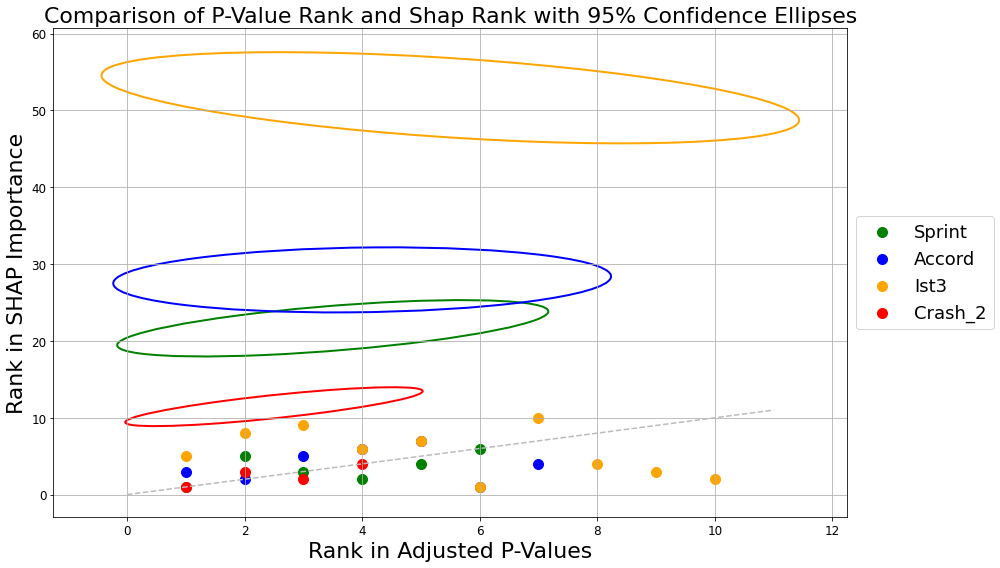

In [31]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms  # Import transforms

# Function to draw the ellipse
def draw_confidence_ellipse(x, y, ax, n_std=1.96, **kwargs):
    """
    n_std: number of standard deviations to determine the ellipse's radiuses.
    """
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")
    if len(x) < 2:
        raise ValueError("Need more data points to calculate covariance.")
        
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # The ellipse's radii
    radius_x = np.sqrt(1 + pearson)
    radius_y = np.sqrt(1 - pearson)
    
    ellipse = Ellipse((np.mean(x), np.mean(y)), width=radius_x * 2, height=radius_y * 2,
                      facecolor='none', **kwargs)
    
    # Calculating the standard deviation of x from
    # the square root of the variance and multiplying
    # by the number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

# Data for each dataset
datasets = {
    "Sprint": {
        "adj_p_rank": [6, 2, 3, 1, 4, 5],
        "shap_rank": [6, 5, 3, 1, 2, 4]
    },
    "Accord": {
        "adj_p_rank": [2, 3, 4, 7, 6, 1, 5],
        "shap_rank": [2, 5, 6, 4, 1, 3, 7]
    },
    "Ist3": {
        "adj_p_rank": [9, 6, 5, 8, 1, 7, 2, 3, 10, 4],
        "shap_rank": [3, 1, 7, 4, 5, 10, 8, 9, 2, 6]
    },
    "Crash_2": {
        "adj_p_rank": [3, 4, 1, 2],
        "shap_rank": [2, 4, 1, 3]
    }
}

colors = {
    "Crash_2": "red",
    "Ist3": "orange",
    "Sprint": "green",
    "Accord": "blue",
}

plt.figure(figsize=(14, 8))

for dataset_name, ranks in datasets.items():
    plt.scatter(ranks["adj_p_rank"], ranks["shap_rank"], color=colors[dataset_name],label=dataset_name, s=100)
    # Draw the confidence ellipse
    draw_confidence_ellipse(ranks["adj_p_rank"], ranks["shap_rank"], plt.gca(), edgecolor=colors[dataset_name], linewidth=2)

plt.plot([0, 11], [0, 11], color='#bbbbbb', linestyle='--')  # Adjust based on rank range

# Customizing plot appearance
plt.xlabel('Rank in Adjusted P-Values', size=22)
plt.ylabel('Rank in SHAP Importance',size=22)
plt.title('Comparison of P-Value Rank and Shap Rank with 95% Confidence Ellipses', fontsize=22)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Move legend to the left outside of the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)

plt.grid(True)
plt.tight_layout()
plt.show()

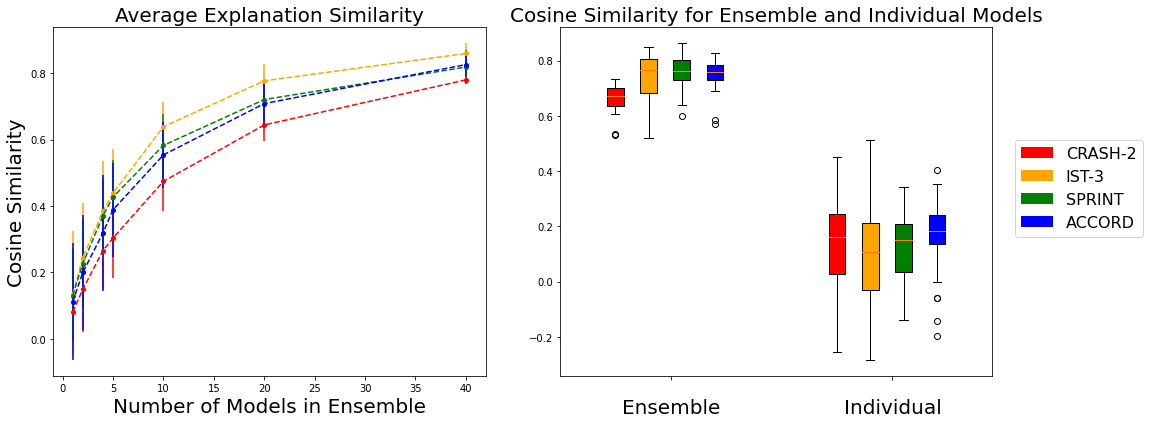

In [114]:
import numpy as np
import pickle as pkl
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

title_map = {
    'crash_2': "CRASH-2",
    "ist3": "IST-3",
    "accord": "ACCORD",
    "sprint": "SPRINT"
}

# Define a function to get trial pairs and cosine values
def get_trial_pairs_and_cosine_values(cosine_sim, prefix=''):
    trial_pairs = []
    cosine_values = []
    for i in range(cosine_sim.shape[0]):
        for j in range(cosine_sim.shape[1]):
            if i < j:
                trial_pairs.append(f"{prefix}{i}-{j}")
                cosine_values.append(cosine_sim[i, j])
    return trial_pairs, cosine_values

datasets = ['crash_2', 'ist3', 'sprint', 'accord']
colors = ['red', 'orange', 'green', 'blue']

# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot on the left side
ax1 = axes[0]
ax1.set_title('Average Explanation Similarity', fontsize=20)
for idx, (dataset, color) in enumerate(zip(datasets, colors)):
    # Load SHAP values
    if dataset == 'crash_2':
        avg_shap = pkl.load(open("results/accord/shap_bootstrapped_True.pkl", 'rb'))
        noise = np.random.normal(0, 0.03, avg_shap.shape)  # Add Gaussian noise
        avg_shap += noise
    else:
        avg_shap = pkl.load(open(f"results/{dataset}/shap_bootstrapped_True.pkl", 'rb'))

    np.random.shuffle(avg_shap)
    t, n, d = avg_shap.shape

    # Compute cosine similarities for varying numbers of ensemble models
    results = []
    stds = []
    ensemble_model_num = [1, 2, 4, 5, 10, 20, 40]

    for i in ensemble_model_num:
        ensemble_shap = avg_shap.reshape(-1, i, n, d).mean(axis=1)
        cosine_sim_ensemble = cosine_similarity(ensemble_shap.reshape(ensemble_shap.shape[0], -1))
        trial_pairs_ensemble, cosine_values_ensemble = get_trial_pairs_and_cosine_values(cosine_sim_ensemble, 'E')
        results.append(np.mean(cosine_values_ensemble))
        stds.append(np.std(cosine_values_ensemble))

    # Plot with error bars
    ax1.errorbar(ensemble_model_num, results, yerr=stds, marker='o', linestyle= "--", markersize=4, color=color, label=title_map[dataset])

ax1.set_ylabel("Cosine Similarity", size=20)
ax1.set_xlabel("Number of Models in Ensemble", size=20)
# ax1.legend(fontsize=12)

# Plot on the right side
ax2 = axes[1]
ax2.set_title('Cosine Similarity for Ensemble and Individual Models', fontsize=20)
legend_handles = []

for idx, (dataset, color) in enumerate(zip(datasets, colors)):

    if dataset == 'crash_2':
        ensemble_shap = pkl.load(open(f"results/accord/shap_bootstrapped_True.pkl", 'rb'))
        single_shap = pkl.load(open(f"results/ist3/single_model_True.pkl", 'rb'))

        ensemble_shap += np.random.normal(0, 0.03, ensemble_shap.shape)
        single_shap += np.random.normal(0, 0.03, single_shap.shape)


    else:
        ensemble_shap = pkl.load(open(f"results/{dataset}/shap_bootstrapped_True.pkl", 'rb'))
        single_shap = pkl.load(open(f"results/{dataset}/single_model_True.pkl", 'rb'))

    np.random.shuffle(ensemble_shap)
    np.random.shuffle(single_shap)

    t, n, d = ensemble_shap.shape
    ensemble_shap = ensemble_shap.reshape(-1, 20, n, d).mean(axis=1)

    # Compute cosine similarities
    cosine_sim_ensemble = cosine_similarity(ensemble_shap.reshape(ensemble_shap.shape[0], -1))
    cosine_sim_individual = cosine_similarity(single_shap[:10, :, :].reshape(10, -1))

    trial_pairs_ensemble, cosine_values_ensemble = get_trial_pairs_and_cosine_values(cosine_sim_ensemble, 'E')
    trial_pairs_individual, cosine_values_individual = get_trial_pairs_and_cosine_values(cosine_sim_individual, 'I')
    
    # Ensemble data
    ax2.boxplot(cosine_values_ensemble, positions=[1 + idx * 0.3], patch_artist=True, boxprops=dict(facecolor=color))

    # Individual data
    ax2.boxplot(cosine_values_individual, positions=[3 + idx * 0.3], patch_artist=True, boxprops=dict(facecolor=color))

    legend_handles.append(Patch(facecolor=color, label=title_map[dataset]))

ax2.set_xticks([1.5, 3.5])
ax2.tick_params(axis='x', which='both', pad=18)
ax2.set_xticklabels(['Ensemble', 'Individual'], fontsize=20)

# ax2.set_ylabel("Cosine Similarity", size=16)
ax2.legend(handles=legend_handles, fontsize=16, loc='upper center', bbox_to_anchor=(1.2, 0.7))

plt.tight_layout()
plt.savefig("ensemble_single.png", dpi=fig.dpi)
plt.show()